# mount google drive

In [115]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [116]:
cd gdrive/My Drive/app/heart_beat/heart_wuxin

[Errno 2] No such file or directory: 'gdrive/My Drive/app/heart_beat/heart_wuxin'
/content/gdrive/My Drive/app/heart_beat/heart_wuxin


In [117]:
pwd

'/content/gdrive/My Drive/app/heart_beat/heart_wuxin'

# read data from csv

In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())

['heart_wuxin.ipynb', 'test_data.csv', 'heart_wuxin.csv', 'heart_wuxin2.csv', 'heart_wuxin3.csv', 'ResNet_50_sig.png', 'ResNet_100_softmax.png', 'kaggle_50_sig.png', 'Conv1D_50_sig.png']


In [0]:
import pandas as pd
df = pd.read_csv("heart_wuxin.csv", header=None)

df2 = pd.read_csv('test_data.csv', header = None)

## test_data label 没打

In [0]:
df2[500] = 1

## 前500列是心跳数据 最后一列是标签 （0为困倦， 1是醒着）

In [0]:
df3 = pd.read_csv("heart_wuxin2.csv", header=None)
df4 = pd.read_csv("heart_wuxin3.csv", header=None)

## 四个表格按行连接

In [0]:
df = pd.concat([df, df2, df3, df4], axis=0)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 207
Columns: 501 entries, 0 to 500
dtypes: float64(500), int64(1)
memory usage: 2.0 MB


In [124]:
df[500].value_counts()

0    344
1    166
Name: 500, dtype: int64

# convert data to numpy array

In [0]:
M = df.values

## split X and y

In [0]:
X = M[:, :-1]
y = M[:, -1].astype(int)

## 获取0和1的索引

In [0]:
import numpy as np
C0 = np.argwhere(y == 0).flatten()  # argwhere 返回索引值 
# flatten 将二维矩阵转换为向量
C1 = np.argwhere(y == 1).flatten()

## 归一化

In [0]:
from sklearn.preprocessing import normalize
X = normalize(X)

# plot ECG

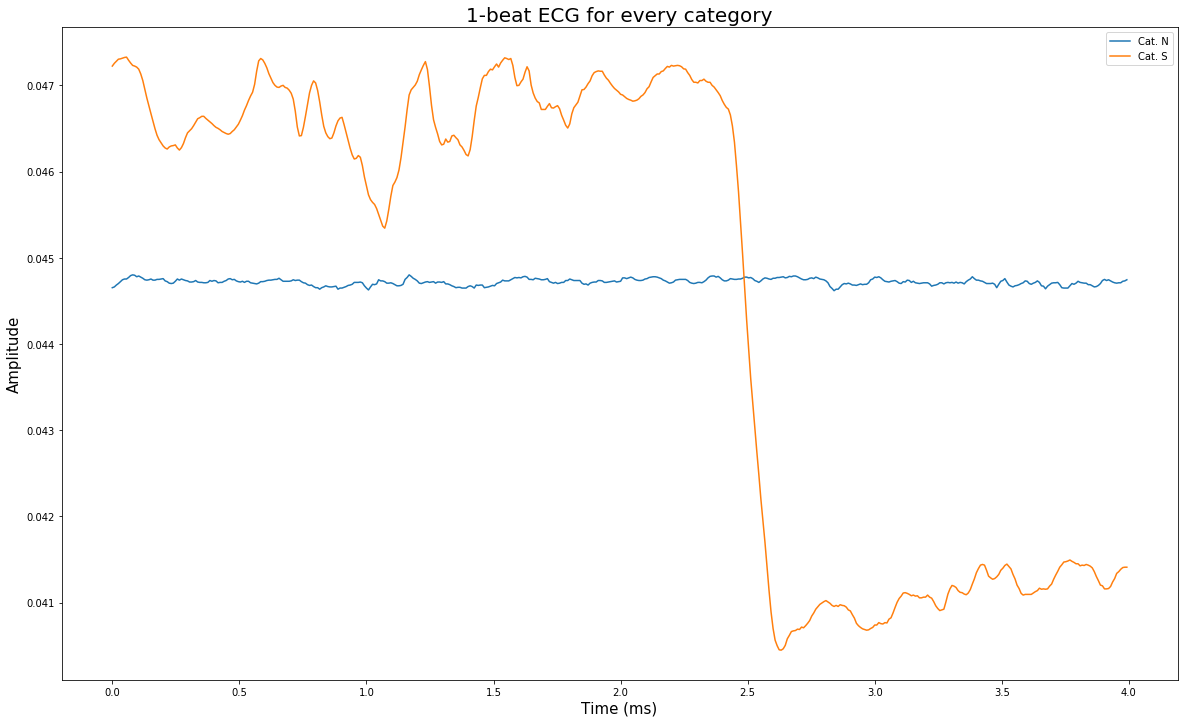

In [98]:
x = np.arange(0, 500)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][19], label="Cat. N")
plt.plot(x, X[C1, :][12], label="Cat. S")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# prepare X and y

# data augmentation (kaggle) 暂时不用

In [0]:
def stretch(x):
    l = int(500 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 500:
        y_ = np.zeros(shape=(500, ))
        y_[:l] = y
    else:
        y_ = y[:500]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 500))
    for i in range(4):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

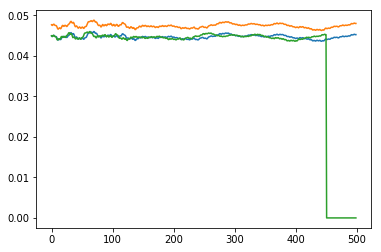

In [0]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

# prepare X for Conv 1D  一维卷积需要添加时间序列维度

In [0]:
X = np.expand_dims(X, -1)

In [157]:
X.shape

(510, 500, 1)

# y to onehot  用softmax需要转成onehot， sigmoid 则不用

In [39]:
y.shape

(510,)

In [0]:
from keras.utils.np_utils import *
y = to_categorical(y, 2)

In [41]:
y.shape

(510, 2)

# Conv1D model from kaggle

In [103]:
from keras.layers import BatchNormalization, Dropout

nb, feature, depth = X.shape
inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(256)(F1)
BN1 = BatchNormalization()(D1)
A6 = Activation("relu")(BN1)
D2 = Dense(128)(A6)
BN2 = BatchNormalization()(D2)
A7 = Activation('relu')(BN2)
dp1 = Dropout(0.5)(A7)
D3 = Dense(1)(dp1)
BN3 = BatchNormalization()(D3)
A8 = Activation('sigmoid')(BN3)

model = Model(inputs=inp, outputs=A8)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 500, 1)       0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 496, 32)      192         input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 496, 32)      5152        conv1d_12[0][0]                  
__________________________________________________________________________________________________
activation_512 (Activation)     (None, 496, 32)      0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_14 

## compile and training

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [106]:
history_tl = model.fit(X, y, 
                    epochs=50,
                    batch_size=400,
                    validation_split=0.3)

Train on 357 samples, validate on 153 samples
Epoch 1/50
357/357 [==============================] - 22s 62ms/step - loss: 0.8264 - acc: 0.4090 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 2/50
357/357 [==============================] - 0s 137us/step - loss: 0.6246 - acc: 0.7255 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 3/50
357/357 [==============================] - 0s 111us/step - loss: 0.5548 - acc: 0.6947 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 4/50
357/357 [==============================] - 0s 109us/step - loss: 0.5285 - acc: 0.7031 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 5/50
357/357 [==============================] - 0s 107us/step - loss: 0.5125 - acc: 0.7591 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 6/50
357/357 [==============================] - 0s 108us/step - loss: 0.4843 - acc: 0.7927 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 7/50
357/357 [==============================] - 0s 110us/step - loss: 0.4809 - acc: 0.8011 - val_loss: 15.9424 - v

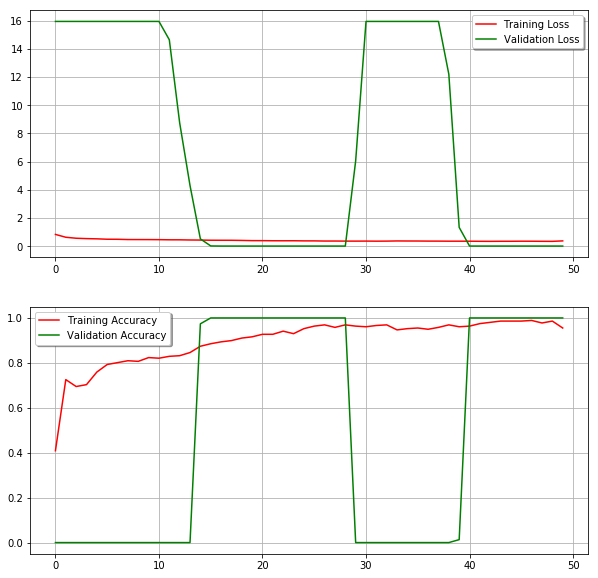

In [108]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_tl.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_tl.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_tl.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_tl.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("Conv1D_50_sig.png")
plt.show()

# design ResNet50 Conv1D(softmax)

In [102]:
import tensorflow as tf

import keras
from keras.engine.input_layer import Input
import keras.backend as K

from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
from keras.engine.topology import Layer

def identity_block(X, f, filter_numbers, stage, block):
    """
    Implementation of the identity block as defined in Figure 4.
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c).
    f -- kernel_size, integer, shape of convolution filter in the main path.
    filter_numbers -- python list of integers, defining the number of filters in the CONV layers of the main path.
    stage -- integer, used to name the layers, depending on their position in the network.
    block -- string/character, used to name the layers, depending on their position in the network.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filter_numbers
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First Conv layer
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    
    # Second Conv layer
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third Conv layer
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)

    # Merge with Residual shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c))
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv1D(F2, f, strides = 1, padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(F3, 1, strides = 1, name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(F3, 1, strides = s, name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 2, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (500, 1), max_pool_s=10, max_strides=5, kernel_size=3, strides = 2, f=3, ave_pool_size=5, n_out=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the 1D data
    n_out -- integer, number of classes or output
    Returns:
    model -- a Model() instance in Keras
    params here were used in one of my projects. 
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = MaxPooling1D(max_pool_s, max_strides)(X_input) 
    
    # Zero-Padding
    X = ZeroPadding1D(3)(X)
    
    # stage 1, 64 filters, kernel_size=7
    X = Conv1D(64, kernel_size, strides=1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    # Stage 2
    X = convolutional_block(X, f, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, f, [16, 16, 64], stage=2, block='b')
    X = identity_block(X, f, [16, 16, 64], stage=2, block='c')

    ### START CODE HERE ###
    
    X = convolutional_block(X, f, filters = [32,32,128], stage = 3, block='a', s = 2)
    X = identity_block(X, f, [32,32,128], stage=3, block='b')
    X = identity_block(X, f, [32,32,128], stage=3, block='c')
    X = identity_block(X, f, [32,32,128], stage=3, block='d')

    # Stage 4 (≈6 lines)
    
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='c')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='d')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='e')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=5, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=5, block='c')

    X = AveragePooling1D(ave_pool_size)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    
    # For regression
    X = Dense(n_out, name='fc-dense', kernel_initializer = glorot_uniform(seed=0), 
              kernel_regularizer=regularizers.l2(0.2), bias_regularizer=regularizers.l2(0.2))(X)
    
    # for classification, if n_out =1, add:  
    # X = Activation('sigmoid')(X)

    # for classification, if n_out > 1, add:  
    X = Activation('softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50_1d')

    return model

model = ResNet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 500, 1)       0                                            
__________________________________________________________________________________________________
max_pooling1d_24 (MaxPooling1D) (None, 99, 1)        0           input_11[0][0]                   
__________________________________________________________________________________________________
zero_padding1d_10 (ZeroPadding1 (None, 105, 1)       0           max_pooling1d_24[0][0]           
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 103, 64)      256         zero_padding1d_10[0][0]          
__________________________________________________________________________________________________
bn_conv1 (

## training

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [64]:
history_res = model.fit(X, y, 
                       validation_split=0.3,
                       batch_size=100,
                       epochs=100)

Train on 357 samples, validate on 153 samples
Epoch 1/100
357/357 [==============================] - 22s 62ms/step - loss: 3.2621 - acc: 0.5406 - val_loss: 16.8707 - val_acc: 0.0000e+00
Epoch 2/100
357/357 [==============================] - 0s 1ms/step - loss: 1.7679 - acc: 0.6891 - val_loss: 16.8596 - val_acc: 0.0000e+00
Epoch 3/100
357/357 [==============================] - 0s 1ms/step - loss: 1.5003 - acc: 0.8319 - val_loss: 16.8476 - val_acc: 0.0000e+00
Epoch 4/100
357/357 [==============================] - 0s 1ms/step - loss: 1.1612 - acc: 0.8683 - val_loss: 16.8351 - val_acc: 0.0000e+00
Epoch 5/100
357/357 [==============================] - 0s 1ms/step - loss: 1.1151 - acc: 0.8964 - val_loss: 16.8222 - val_acc: 0.0000e+00
Epoch 6/100
357/357 [==============================] - 0s 1ms/step - loss: 1.0848 - acc: 0.9300 - val_loss: 16.8088 - val_acc: 0.0000e+00
Epoch 7/100
357/357 [==============================] - 0s 1ms/step - loss: 1.0363 - acc: 0.9216 - val_loss: 16.7948 - val_ac

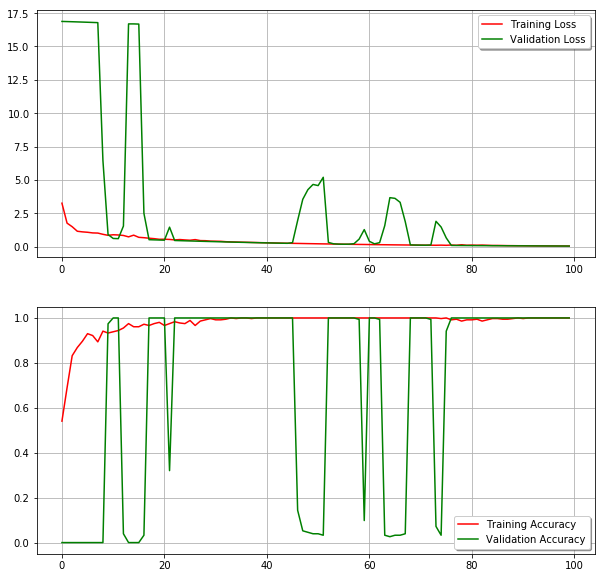

In [83]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_res.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_res.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_res.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_res.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("ResNet_100_softmax.png")
plt.show()

# ResNet 50 sigmoid

In [197]:
import tensorflow as tf

import keras
from keras.engine.input_layer import Input
import keras.backend as K

from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
from keras.engine.topology import Layer

def identity_block(X, f, filter_numbers, stage, block):
    """
    Implementation of the identity block as defined in Figure 4.
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c).
    f -- kernel_size, integer, shape of convolution filter in the main path.
    filter_numbers -- python list of integers, defining the number of filters in the CONV layers of the main path.
    stage -- integer, used to name the layers, depending on their position in the network.
    block -- string/character, used to name the layers, depending on their position in the network.
    
    Returns:
    X -- output of the identity block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filter_numbers
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First Conv layer
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    
    # Second Conv layer
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third Conv layer
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)

    # Merge with Residual shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, input_length_prev (n_w), input_Channel_prev (n_c))
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv1D(F2, f, strides = 1, padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(F3, 1, strides = 1, name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(F3, 1, strides = s, name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 2, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (500, 1), max_pool_s=10, max_strides=5, kernel_size=3, strides = 2, f=3, ave_pool_size=5, n_out=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the 1D data
    n_out -- integer, number of classes or output
    Returns:
    model -- a Model() instance in Keras
    params here were used in one of my projects. 
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = MaxPooling1D(max_pool_s, max_strides)(X_input) 
    
    # Zero-Padding
    X = ZeroPadding1D(3)(X)
    
    # stage 1, 64 filters, kernel_size=7
    X = Conv1D(64, kernel_size, strides=1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    # Stage 2
    X = convolutional_block(X, f, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, f, [16, 16, 64], stage=2, block='b')
    X = identity_block(X, f, [16, 16, 64], stage=2, block='c')

    ### START CODE HERE ###
    
    X = convolutional_block(X, f, filters = [32,32,128], stage = 3, block='a', s = 2)
    X = identity_block(X, f, [32,32,128], stage=3, block='b')
    X = identity_block(X, f, [32,32,128], stage=3, block='c')
    X = identity_block(X, f, [32,32,128], stage=3, block='d')

    # Stage 4 (≈6 lines)
    
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='c')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='d')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='e')
    X = identity_block(X, f, [64, 64, 256], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f, filters = [64, 64, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, f, [64, 64, 256], stage=5, block='b')
    X = identity_block(X, f, [64, 64, 256], stage=5, block='c')

    X = AveragePooling1D(ave_pool_size)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    
    # For regression
    X = Dense(n_out, name='fc-dense', kernel_initializer = glorot_uniform(seed=0), 
              kernel_regularizer=regularizers.l2(0.2), bias_regularizer=regularizers.l2(0.2))(X)
    
    # for classification, if n_out =1, add:  
    X = Activation('sigmoid')(X)

    # for classification, if n_out > 1, add:  
    # X = Activation('softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50_1d')

    return model

model = ResNet50(n_out=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 500, 1)       0                                            
__________________________________________________________________________________________________
max_pooling1d_35 (MaxPooling1D) (None, 99, 1)        0           input_18[0][0]                   
__________________________________________________________________________________________________
zero_padding1d_13 (ZeroPadding1 (None, 105, 1)       0           max_pooling1d_35[0][0]           
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 103, 64)      256         zero_padding1d_13[0][0]          
__________________________________________________________________________________________________
bn_conv1 (

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='ResNet1D.png')

In [176]:
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
history_res_sig = model.fit(X, y,
         batch_size=400,
         epochs=50,
         validation_split=0.3)

Train on 357 samples, validate on 153 samples
Epoch 1/50
357/357 [==============================] - 33s 94ms/step - loss: 3.0719 - acc: 0.4678 - val_loss: 16.3453 - val_acc: 0.0000e+00
Epoch 2/50
357/357 [==============================] - 0s 418us/step - loss: 1.6160 - acc: 0.5182 - val_loss: 16.3437 - val_acc: 0.0000e+00
Epoch 3/50
357/357 [==============================] - 0s 384us/step - loss: 1.7871 - acc: 0.5686 - val_loss: 16.3418 - val_acc: 0.0000e+00
Epoch 4/50
357/357 [==============================] - 0s 384us/step - loss: 1.4731 - acc: 0.5518 - val_loss: 16.3398 - val_acc: 0.0000e+00
Epoch 5/50
357/357 [==============================] - 0s 318us/step - loss: 1.1594 - acc: 0.7003 - val_loss: 16.3378 - val_acc: 0.0000e+00
Epoch 6/50
357/357 [==============================] - 0s 285us/step - loss: 1.1958 - acc: 0.7087 - val_loss: 16.3357 - val_acc: 0.0000e+00
Epoch 7/50
357/357 [==============================] - 0s 288us/step - loss: 0.9503 - acc: 0.7871 - val_loss: 16.3336 - v

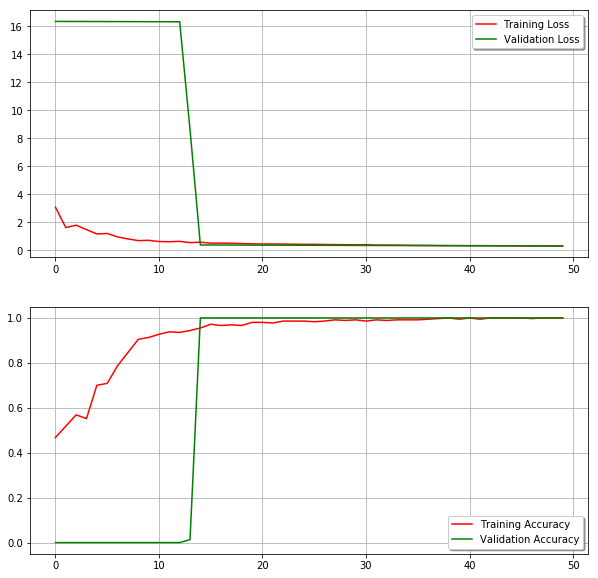

In [177]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_res_sig.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_res_sig.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_res_sig.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_res_sig.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("ResNet_502.png")
plt.show()

In [0]:
model.save('ResNet_50_2.h5')

## draw confusion matrix

In [179]:
model_res = load_model('ResNet_50_2.h5')
model_res.evaluate(X, y)

510/510 [==============================] - 11s 21ms/step


[5.541794764878703, 0.6745098039215687]

In [182]:
model_res.evaluate(X[400:450], y[400:450])

50/50 [==============================] - 0s 1ms/step


[0.2955128848552704, 1.0]

In [183]:
from keras.models import load_model
true_name = []
for i in y[400:450]:
  if i==0:
    true_name.append('Drowsiness')
  else:
    true_name.append('Awake')
print(true_name)

['Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness', 'Drowsiness']


In [172]:
len(true_name)

50

In [0]:
pred = model_res.predict(X[200:250])

In [174]:
pred

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [0]:
#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#



#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class():
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    y_test = np.array(true_label)
    predic = np.array(predicted_class_indices)
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = list(cloud_dict.keys())
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 12;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=9; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
#


#
#MAIN function
#
if(__name__ == '__main__'):
    print('__main__')
    print('_test_cm: test function with confusion matrix done\nand pause')
    _test_cm()
    plt.pause(5)
    print('_test_data_class: test function with y_test (actual values) and predictions (predic)')
    _test_data_class()

# design Dense network

In [191]:
nb, feature = X.shape
inp = Input(shape=(feature,))
fc1 = Dense(256)(inp)
bn1 = BatchNormalization()(fc1)
ac1 = Activation('relu')(bn1)
fc2 = Dense(128)(ac1)
bn2 = BatchNormalization()(fc2)
ac2 = Activation('relu')(bn2)
dp2 = Dropout(0.5)(ac2)
fc3 = Dense(32)(dp2)
bn3 = BatchNormalization()(fc3)
ac3 = Activation('relu')(bn3)
dp3 = Dropout(0.5)(ac3)
fc4 = Dense(1)(dp3)
ac4 = Activation('sigmoid')(fc4)
model_dense = Model(inputs=inp, outputs=ac4)
model_dense.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               128256    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
activation_631 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
activation_632 (Activation)  (None, 128)               0         
__________

In [0]:
model_dense.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [193]:
history_dense = model_dense.fit(X, y, 
                    epochs=50, 
                    batch_size=400,
                    validation_split=0.3)

Train on 357 samples, validate on 153 samples
Epoch 1/50
357/357 [==============================] - 28s 77ms/step - loss: 0.9567 - acc: 0.4818 - val_loss: 0.0544 - val_acc: 0.9935
Epoch 2/50
357/357 [==============================] - 0s 84us/step - loss: 0.8673 - acc: 0.5546 - val_loss: 0.1234 - val_acc: 0.9869
Epoch 3/50
357/357 [==============================] - 0s 63us/step - loss: 0.7258 - acc: 0.5882 - val_loss: 0.5962 - val_acc: 0.8889
Epoch 4/50
357/357 [==============================] - 0s 70us/step - loss: 0.6816 - acc: 0.6162 - val_loss: 2.1447 - val_acc: 0.0065
Epoch 5/50
357/357 [==============================] - 0s 69us/step - loss: 0.6376 - acc: 0.6303 - val_loss: 4.0737 - val_acc: 0.0000e+00
Epoch 6/50
357/357 [==============================] - 0s 60us/step - loss: 0.5648 - acc: 0.6639 - val_loss: 4.9397 - val_acc: 0.0000e+00
Epoch 7/50
357/357 [==============================] - 0s 61us/step - loss: 0.5758 - acc: 0.6891 - val_loss: 5.8432 - val_acc: 0.0000e+00
Epoch 8/50

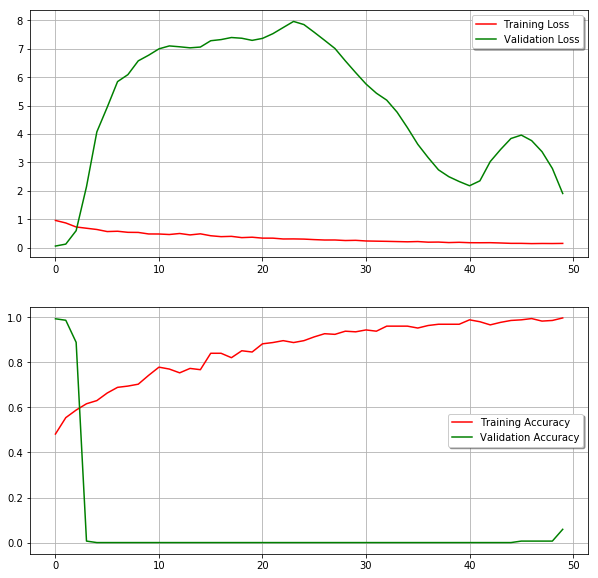

In [196]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history_dense.history['loss'], color='r', label='Training Loss')
ax[0].plot(history_dense.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)

ax[1].plot(history_dense.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history_dense.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)
plt.savefig("dense_50_sig.png")
plt.show()